In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

## Setup Experiments

In [2]:
# N_points = 10_000
# N_arcs = 100_000 
# N_time = 100
N_points = 500
N_arcs = 5000
N_time = 50

# Arcs start- and end-points
xindex = np.arange(N_arcs)
yidx_start = np.random.randint(0, N_points, size=N_arcs)
shift = np.random.randint(1, N_points, size=N_arcs)
yidx_end = (yidx_start + shift) % N_points

# y - arc ambiguities 
# Assuming 5% of +1 and 5% of -1 
y = np.random.choice([-1, 0, 1], (N_arcs, N_time), p=[0.05, 0.90, 0.05])

## 1. Numpy via matrix inversion

Setup the matrix as a (dense) numpy array:

In [3]:
# A - design matrix, in "dense" form
A = np.zeros((N_arcs, N_points), dtype=int)
A[xindex, yidx_end] = 1
A[xindex, yidx_start] = -1

Trying to solve the problem "directly" via matrix inversion of $A^T A$:

$$x = (A^T A)^{-1} A^T y$$

In [4]:
%%time
x_1 = np.linalg.inv(A.T @ A) @ A.T @ y

CPU times: user 6.21 s, sys: 133 ms, total: 6.35 s
Wall time: 6.21 s


In [5]:
x_1.shape

(500, 50)

Plot the histogram of all values, to compare with other solutions:

(-1.0, 1.0)

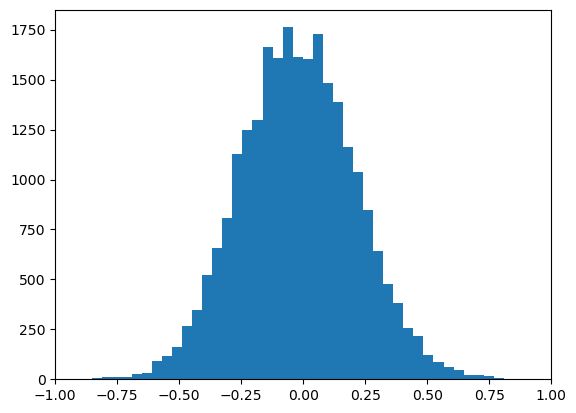

In [6]:
plt.hist(x_1.flatten(), bins=50)
plt.xlim([-1, 1])

This approach suffers from numerical noise due to the matrix inversion step:

In [7]:
N = A.T @ A
N_inv = np.linalg.inv(N)

In [8]:
# This should be equal to the identity matrix, but there is clearly
# numerical noise
N_inv @ N 

array([[ 1.03125, -0.0625 ,  0.     , ..., -0.0625 , -0.0625 , -0.03125],
       [ 0.     ,  0.9375 ,  0.125  , ...,  0.     ,  0.     ,  0.     ],
       [ 0.09375,  0.     ,  1.1875 , ...,  0.125  , -0.125  ,  0.03125],
       ...,
       [ 0.09375, -0.125  ,  0.0625 , ...,  1.1875 , -0.0625 , -0.0625 ],
       [ 0.09375, -0.0625 ,  0.0625 , ...,  0.1875 ,  1.0625 ,  0.     ],
       [ 0.     , -0.125  ,  0.     , ...,  0.     ,  0.     ,  0.96875]],
      shape=(500, 500))

## 2. Numpy least-square solution

Numpy implements solvers for linears systems of the form `Ax = b`:
- `np.linalg.solve` only works for square, full-rank matrices.
- For other systems, one can find (approximate) least-squares solution via `np.linalg.lstsq`

In [9]:
%%time
x_2, residuals, rank, s = np.linalg.lstsq(A, y)

CPU times: user 1.45 s, sys: 66.7 ms, total: 1.52 s
Wall time: 218 ms


This is significantly faster than the previous approach. 

In [10]:
x_2.shape

(500, 50)

The distribution of the values is somewhat different from the one obtained earlier (this is clearer for smaller `N_*` values, where one sees the distribution is sharper - does this mean the numerical accuracy is higher?)

(-1.0, 1.0)

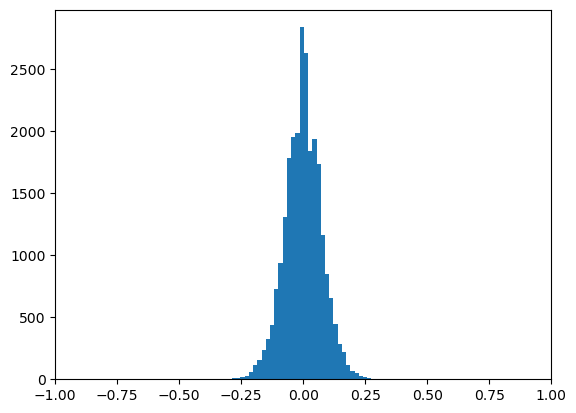

In [11]:
plt.hist(x_2.flatten(), bins=50)
plt.xlim([-1, 1])

## Solution 3: Scipy sparse matrices

We can then setup a similar least-squares solution using [Scipy's support for sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html). We setup the A matrix as a sparse matrix using `scipy.sparse`. We use this library rather than [sparse](https://sparse.pydata.org/en/stable/) since Scipy also implements linear algebra solvers such as least-squares optimizers.

In [12]:
# A - design matrix, in "sparse" form
end = scipy.sparse.coo_array((np.ones_like(xindex), (xindex, yidx_end)))
start = scipy.sparse.coo_array((-np.ones_like(xindex), (xindex, yidx_start)))
A_sparse = start + end

In [13]:
# Verify the sparse matrix is equivalent to its dense counterpart
assert np.allclose(A_sparse.todense(), A), "Problem in setting up sparse matrix"

The sparse solver `scipy.sparse.linalg.lsmr` only accepts single-column coefficients, so one needs to "loop" over the columns of $y$ (the time axis). We lower the tolerance compared to the default value (1.e-6) so that we get results equivalent to the "dense" solution:

In [14]:
@np.vectorize(signature="(i)->(j)")
def lsmr(y, tol=1.e-10):
    x, *_ = scipy.sparse.linalg.lsmr(A_sparse, y, atol=tol, btol=tol)
    return x

In [15]:
%%time
x_3 = lsmr(y.T).T  # double traspose should be fixed..

CPU times: user 136 ms, sys: 8.57 ms, total: 145 ms
Wall time: 146 ms


The solution should be equivalent to the corresponding "dense" solution (if not, one can make tolerance smaller):

In [16]:
np.allclose(x_3, x_2)

True

This turns out to be the fastest approach! And even with the following input parameters it takes a few seconds.

In [17]:
N_points = 10_000
N_arcs = 100_000 
N_time = 100